# Supermasks in Superposition: Training and Task Inference

<img src="images/teaser_supsup.png">

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F

import torchvision
import numpy as np
import math

from tqdm.notebook import tqdm

print("Packages loaded")
# note at edits

Packages loaded


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Training

We train our model using the procedure from "What's Hidden in a Randomly Weighted Neural Network" (Ramanujan et al. 2019). Below is a modification of the layers (using signed constant initialization) from this paper for our continual learning setup. As a deviation from this setup, we assume that an edge (u, v) is included in the subnetwork if its score is greater than 0, rather than use it's absolute magnitude to construct a threshold. 

In [3]:
# Subnetwork forward from hidden networks   
class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the supermask by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None

def mask_init(module):
    scores = torch.Tensor(module.weight.size())
    nn.init.kaiming_uniform_(scores, a=math.sqrt(5))
    return scores


def signed_constant(module):
    fan = nn.init._calculate_correct_fan(module.weight, 'fan_in')
    gain = nn.init.calculate_gain('relu')
    std = gain / math.sqrt(fan)
    module.weight.data = module.weight.data.sign() * std


class MultitaskMaskLinear(nn.Linear):
    def __init__(self, *args, num_tasks=1, sparsity=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_tasks = num_tasks
        self.sparsity = sparsity
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        
        # Keep weights untrained
        self.weight.requires_grad = False
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnet.apply(self.scores[j], self.sparsity)
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            # Superimposed forward pass
            alpha_weights = self.alphas[: self.num_tasks_learned]
            idxs = (alpha_weights > 0).squeeze().view(self.num_tasks_learned)
            if len(idxs.shape) == 0:
                idxs = idxs.view(1)
            subnet = (
                alpha_weights[idxs]
                * self.stacked[: self.num_tasks_learned][idxs]
            ).sum(dim=0)
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = GetSubnet.apply(self.scores[self.task], self.sparsity)
        w = self.weight * subnet
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"MultitaskMaskLinear({self.shape()})"

In [4]:
class BasisMultitaskMaskLinear(nn.Linear):
    def __init__(self, *args, num_tasks=1, num_seed_tasks_learned=1, start_at_optimal=True, sparsity=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        assert num_tasks >= num_seed_tasks_learned, "Seed tasks cannot be more than total tasks!"
        self.num_tasks = num_tasks
        self.num_seed_tasks_learned = num_seed_tasks_learned
        self.sparsity = sparsity
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        self.task = -1
        
        # Keep weights untrained
        self.weight.requires_grad = False
        for s in self.scores:
            s.requires_grad = False
        self.scores.requires_grad = False
        if start_at_optimal:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.eye(self.num_seed_tasks_learned)[i])
                    for i in range(self.num_seed_tasks_learned)
                ]
                +
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_seed_tasks_learned, self.num_tasks)
                ]
            )
        else:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_tasks)
                ]
            )
        
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnet.apply(self.scores[j], self.sparsity)
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            raise NotImplemented("Need task identity at inference time.")
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = self.stacked[: self.num_seed_tasks_learned][0]
            task_alpha = self.basis_alphas[self.task]
            w = self.weight * subnet * task_alpha[0]
            for i in range(1, self.num_seed_tasks_learned):
                subnet = self.stacked[: self.num_seed_tasks_learned][i]
                w += self.weight * subnet * task_alpha[i]
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"BasisMultitaskMaskLinear({self.shape()})"

In [5]:
class BasisMultitaskMaskLinearFrozen(nn.Linear):
    def __init__(self, *args, num_tasks=1, num_seed_tasks_learned=1, start_at_optimal=True, sparsity=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        assert num_tasks >= num_seed_tasks_learned, "Seed tasks cannot be more than total tasks!"
        self.num_tasks = num_tasks
        self.sparsity = sparsity
        self.num_seed_tasks_learned = num_seed_tasks_learned
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        self.task = -1
        
        # Keep weights untrained
        self.weight.requires_grad = False
        for s in self.scores:
            s.requires_grad = False
        self.scores.requires_grad = False
        if start_at_optimal:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.eye(self.num_seed_tasks_learned)[i])
                    for i in range(self.num_seed_tasks_learned)
                ]
                +
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_seed_tasks_learned, self.num_tasks)
                ]
            )
        else:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_tasks)
                ]
            )
        for a in self.basis_alphas:
            a.requires_grad = False
        self.basis_alphas.requires_grad = False
        
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnet.apply(self.scores[j], self.sparsity)
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            raise NotImplemented("Need task identity at inference time.")
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = self.stacked[: self.num_seed_tasks_learned][0]
            task_alpha = self.basis_alphas[self.task]
            w = self.weight * subnet * task_alpha[0]
            for i in range(1, self.num_seed_tasks_learned):
                subnet = self.stacked[: self.num_seed_tasks_learned][i]
                w += self.weight * subnet * task_alpha[i]
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"BasisMultitaskMaskLinearFrozen({self.shape()})"

In [6]:
ValidConvs = [
    MultitaskMaskLinear,
    BasisMultitaskMaskLinear,
    BasisMultitaskMaskLinearFrozen,
]

def isoftype(m, cls_lst):
    return any([isinstance(m, c) for c in cls_lst])

In [7]:
# Utility functions
def set_model_task(model, task, verbose=True):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            if verbose:
                print(f"=> Set task of {n} to {task}")
            m.task = task

def cache_masks(model):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            print(f"=> Caching mask state for {n}")
            m.cache_masks()

def set_num_tasks_learned(model, num_tasks_learned):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            print(f"=> Setting learned tasks of {n} to {num_tasks_learned}")
            m.num_tasks_learned = num_tasks_learned

def set_alphas(model, alphas, verbose=True):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            if verbose:
                print(f"=> Setting alphas for {n}")
            m.alphas = alphas

## Model

For simplicity we use a simple 3-layer fully connected neural network. Note that you can make any neural by replacing a standard layer with its corresponding mask layer.

In [8]:
# Multitask Model, a simple fully connected model in this case
class MultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, sparsity):
        super().__init__()
        self.model = nn.Sequential(
            MultitaskMaskLinear(
                784,
                hidden_size,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [9]:
# Multitask Model, a simple fully connected model in this case
class BasisMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, sparsity, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinear(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinear(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [10]:
class BasisHiddenOnlyMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, sparsity, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinear(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinear(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [11]:
class BasisHiddenOnlyFrozenMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, sparsity, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinearFrozen(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinearFrozen(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

## Dataset 

Our "base" dataset is MNIST. Each task is a random permutation of the pixels of MNIST. Namely, given a dataset $\{(x_i, y_i)\}_i$ for each task $t$, we take a random permutation $S^t\in S_{784}$ and construct a dataset $\{(S^t(x_i), y_i)\}_i$. 

Below we show this process and an example of a particular task. `MNISTPerm` uses an update task method to generate a particular sub-task. To assure these splits are reproducible, `MNISTPerm` takes a `seed` argument. In our paper we evaluate on seeds 0 through 4.

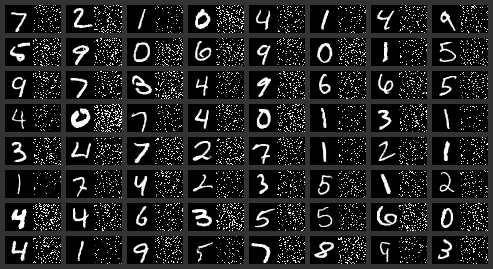

In [12]:
class MNISTPerm:
    class permute(object):
        def __call__(self, tensor):
            out = tensor.flatten()
            out = out[self.perm]
            return out.view(1, 28, 28)

        def __repr__(self):
            return self.__class__.__name__

    def __init__(self, seed=0):
        super(MNISTPerm, self).__init__()
        
        data_root = "mnist"
        self.permuter = self.permute()
        self.seed = seed
        train_dataset = torchvision.datasets.MNIST(
            data_root,
            train=True,
            download=True,
            transform=torchvision.transforms.Compose(
                [
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                    self.permuter,
                ]
            ),
        )

        # Data loading code
        self.train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=128, shuffle=True
        )
        self.val_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(
                data_root,
                train=False,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                        self.permuter,
                    ]
                ),
            ),
            batch_size=128,
            shuffle=False,
        )

    def update_task(self, i):
        np.random.seed(i + self.seed)
        self.permuter.__setattr__("perm", np.random.permutation(784))
    
    def unpermute(self):
        self.permuter.__setattr__("perm", np.arange(784))

mnist = MNISTPerm()

# Showing some example images from MNISTPerm
mnist.unpermute()
batch, labels = next(iter(mnist.val_loader))

mnist.update_task(0)
task0, labels = next(iter(mnist.val_loader))

torchvision.transforms.ToPILImage()(
    torchvision.utils.make_grid(
        torch.cat([batch, task0], dim=-1)[:64],
        normalize=True,
        padding=5,
        pad_value=0.2
    )
)

### Simple train and evaluation loops for classification

In [13]:
# Finding supermasks per task

def train(model, trainloader, optimizer, epoch):
    model.train()

    criterion = nn.CrossEntropyLoss()
    num_correct = 0
    total_seen = 0
    for i, (batch, labels) in tqdm(
        enumerate(trainloader),
        ascii=True,
        total=len(trainloader)
    ):
        logits = model(batch)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 20 == 0:
            predictions = logits.argmax(dim=-1)
            num_correct += (predictions == labels).float().sum()
            total_seen += logits.size(0) 
            tqdm.write(
                (f"e{epoch} {i+1}/{len(trainloader)}"
                f" => Loss {loss.item():0.4f}, "
                f"Acc@1 {(num_correct / total_seen):0.4f}"),
                end="\r"
            )


@torch.no_grad()
def evaluate(model, val_loader, epoch):
    model.eval()
    num_correct = 0
    total_seen = 0
    for batch, labels in tqdm(
        val_loader,
        ascii=True,
        total=len(val_loader)
    ):
        logits = model(batch)
        predictions = logits.argmax(dim=-1)
        num_correct += (predictions == labels).float().sum()
        total_seen += logits.size(0) 
    

    tqdm.write(
        f"Val Perf after {epoch + 1} epochs "
        f"Acc@1 {(num_correct / total_seen):0.4f}", 
    )
    return num_correct / total_seen



For any scenario where task ID is given during train time, we simply train each supermask independently, one per task. We make use of our utility function `set_model_task` to do this. We use 5 tasks for demonstration purposes. Feel free to increase `num_tasks` in the following cell. In our paper we use as many as 2500 tasks with no drop in performance for either task inference or validation accuracy.

In [14]:
performance_map = {}

In [15]:
# Task ID given during train time
from IPython.display import clear_output

num_tasks = 50 # For demonstration purposes, we go up to 2500 in our paper
model = MultitaskFC(hidden_size=300, num_tasks=num_tasks, sparsity=0.25)

for task in range(num_tasks):
    print(f"Training for task {task}")
    set_model_task(model, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in model.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(model, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(model, mnist.val_loader, e)
        
    
    cache_masks(model)
    print()
    set_num_tasks_learned(model, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3245, Acc@1 0.8503


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9123
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3080, Acc@1 0.8350


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9123
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3267, Acc@1 0.8408


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9141
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3086, Acc@1 0.8369


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9144
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2680, Acc@1 0.8392


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9112
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3552, Acc@1 0.8206


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9153
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3098, Acc@1 0.8379


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9124
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7

Training for task 7
=> Set task of model.0 to 7
=> Set task of model.2 to 7
=> Set task of model.4 to 7


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2037, Acc@1 0.8356


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9112
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 8
=> Setting learned tasks of model.2 to 8
=> Setting learned tasks of model.4 to 8

Training for task 8
=> Set task of model.0 to 8
=> Set task of model.2 to 8
=> Set task of model.4 to 8


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3045, Acc@1 0.8467


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9154
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 9
=> Setting learned tasks of model.2 to 9
=> Setting learned tasks of model.4 to 9

Training for task 9
=> Set task of model.0 to 9
=> Set task of model.2 to 9
=> Set task of model.4 to 9


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3043, Acc@1 0.8395


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9143
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 10
=> Setting learned tasks of model.2 to 10
=> Setting learned tasks of model.4 to 10

Training for task 10
=> Set task of model.0 to 10
=> Set task of model.2 to 10
=> Set task of model.4 to 10


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2701, Acc@1 0.8340


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9144
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 11
=> Setting learned tasks of model.2 to 11
=> Setting learned tasks of model.4 to 11

Training for task 11
=> Set task of model.0 to 11
=> Set task of model.2 to 11
=> Set task of model.4 to 11


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3938, Acc@1 0.8333


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9104
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 12
=> Setting learned tasks of model.2 to 12
=> Setting learned tasks of model.4 to 12

Training for task 12
=> Set task of model.0 to 12
=> Set task of model.2 to 12
=> Set task of model.4 to 12


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4059, Acc@1 0.8382


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9161
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 13
=> Setting learned tasks of model.2 to 13
=> Setting learned tasks of model.4 to 13

Training for task 13
=> Set task of model.0 to 13
=> Set task of model.2 to 13
=> Set task of model.4 to 13


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3382, Acc@1 0.8431


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9120
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 14
=> Setting learned tasks of model.2 to 14
=> Setting learned tasks of model.4 to 14

Training for task 14
=> Set task of model.0 to 14
=> Set task of model.2 to 14
=> Set task of model.4 to 14


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3124, Acc@1 0.8337


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9123
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 15
=> Setting learned tasks of model.2 to 15
=> Setting learned tasks of model.4 to 15

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4136, Acc@1 0.8327


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9117
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2937, Acc@1 0.8356


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9107
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3734, Acc@1 0.8320


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9143
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3568, Acc@1 0.8369


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9106
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3247, Acc@1 0.8424


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9048
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20

Training for task 20
=> Set task of model.0 to 20
=> Set task of model.2 to 20
=> Set task of model.4 to 20


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4031, Acc@1 0.8411


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9109
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 21
=> Setting learned tasks of model.2 to 21
=> Setting learned tasks of model.4 to 21

Training for task 21
=> Set task of model.0 to 21
=> Set task of model.2 to 21
=> Set task of model.4 to 21


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2920, Acc@1 0.8473


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9132
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 22
=> Setting learned tasks of model.2 to 22
=> Setting learned tasks of model.4 to 22

Training for task 22
=> Set task of model.0 to 22
=> Set task of model.2 to 22
=> Set task of model.4 to 22


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2815, Acc@1 0.8447


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9125
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 23
=> Setting learned tasks of model.2 to 23
=> Setting learned tasks of model.4 to 23

Training for task 23
=> Set task of model.0 to 23
=> Set task of model.2 to 23
=> Set task of model.4 to 23


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2969, Acc@1 0.8464


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9118
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 24
=> Setting learned tasks of model.2 to 24
=> Setting learned tasks of model.4 to 24

Training for task 24
=> Set task of model.0 to 24
=> Set task of model.2 to 24
=> Set task of model.4 to 24


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4044, Acc@1 0.8385


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9130
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 25
=> Setting learned tasks of model.2 to 25
=> Setting learned tasks of model.4 to 25

Training for task 25
=> Set task of model.0 to 25
=> Set task of model.2 to 25
=> Set task of model.4 to 25


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4173, Acc@1 0.8369


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9115
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 26
=> Setting learned tasks of model.2 to 26
=> Setting learned tasks of model.4 to 26

Training for task 26
=> Set task of model.0 to 26
=> Set task of model.2 to 26
=> Set task of model.4 to 26


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3948, Acc@1 0.8366


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9131
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 27
=> Setting learned tasks of model.2 to 27
=> Setting learned tasks of model.4 to 27

Training for task 27
=> Set task of model.0 to 27
=> Set task of model.2 to 27
=> Set task of model.4 to 27


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2693, Acc@1 0.8434


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9118
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 28
=> Setting learned tasks of model.2 to 28
=> Setting learned tasks of model.4 to 28

Training for task 28
=> Set task of model.0 to 28
=> Set task of model.2 to 28
=> Set task of model.4 to 28


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2965, Acc@1 0.8340


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9121
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 29
=> Setting learned tasks of model.2 to 29
=> Setting learned tasks of model.4 to 29

Training for task 29
=> Set task of model.0 to 29
=> Set task of model.2 to 29
=> Set task of model.4 to 29


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3118, Acc@1 0.8382


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9135
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 30
=> Setting learned tasks of model.2 to 30
=> Setting learned tasks of model.4 to 30

Training for task 30
=> Set task of model.0 to 30
=> Set task of model.2 to 30
=> Set task of model.4 to 30


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2714, Acc@1 0.8330


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9107
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 31
=> Setting learned tasks of model.2 to 31
=> Setting learned tasks of model.4 to 31

Training for task 31
=> Set task of model.0 to 31
=> Set task of model.2 to 31
=> Set task of model.4 to 31


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2569, Acc@1 0.8542


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9081
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 32
=> Setting learned tasks of model.2 to 32
=> Setting learned tasks of model.4 to 32

Training for task 32
=> Set task of model.0 to 32
=> Set task of model.2 to 32
=> Set task of model.4 to 32


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4106, Acc@1 0.8366


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9130
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 33
=> Setting learned tasks of model.2 to 33
=> Setting learned tasks of model.4 to 33

Training for task 33
=> Set task of model.0 to 33
=> Set task of model.2 to 33
=> Set task of model.4 to 33


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3629, Acc@1 0.8424


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9117
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 34
=> Setting learned tasks of model.2 to 34
=> Setting learned tasks of model.4 to 34

Training for task 34
=> Set task of model.0 to 34
=> Set task of model.2 to 34
=> Set task of model.4 to 34


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3691, Acc@1 0.8421


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9147
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 35
=> Setting learned tasks of model.2 to 35
=> Setting learned tasks of model.4 to 35

Training for task 35
=> Set task of model.0 to 35
=> Set task of model.2 to 35
=> Set task of model.4 to 35


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3246, Acc@1 0.8376


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9117
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 36
=> Setting learned tasks of model.2 to 36
=> Setting learned tasks of model.4 to 36

Training for task 36
=> Set task of model.0 to 36
=> Set task of model.2 to 36
=> Set task of model.4 to 36


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2534, Acc@1 0.8320


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9124
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 37
=> Setting learned tasks of model.2 to 37
=> Setting learned tasks of model.4 to 37

Training for task 37
=> Set task of model.0 to 37
=> Set task of model.2 to 37
=> Set task of model.4 to 37


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2380, Acc@1 0.8483


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9122
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 38
=> Setting learned tasks of model.2 to 38
=> Setting learned tasks of model.4 to 38

Training for task 38
=> Set task of model.0 to 38
=> Set task of model.2 to 38
=> Set task of model.4 to 38


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3894, Acc@1 0.8438


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9070
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 39
=> Setting learned tasks of model.2 to 39
=> Setting learned tasks of model.4 to 39

Training for task 39
=> Set task of model.0 to 39
=> Set task of model.2 to 39
=> Set task of model.4 to 39


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2793, Acc@1 0.8379


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9134
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 40
=> Setting learned tasks of model.2 to 40
=> Setting learned tasks of model.4 to 40

Training for task 40
=> Set task of model.0 to 40
=> Set task of model.2 to 40
=> Set task of model.4 to 40


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3157, Acc@1 0.8307


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9108
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 41
=> Setting learned tasks of model.2 to 41
=> Setting learned tasks of model.4 to 41

Training for task 41
=> Set task of model.0 to 41
=> Set task of model.2 to 41
=> Set task of model.4 to 41


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4216, Acc@1 0.8464


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9113
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 42
=> Setting learned tasks of model.2 to 42
=> Setting learned tasks of model.4 to 42

Training for task 42
=> Set task of model.0 to 42
=> Set task of model.2 to 42
=> Set task of model.4 to 42


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2464, Acc@1 0.8395


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9129
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 43
=> Setting learned tasks of model.2 to 43
=> Setting learned tasks of model.4 to 43

Training for task 43
=> Set task of model.0 to 43
=> Set task of model.2 to 43
=> Set task of model.4 to 43


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2216, Acc@1 0.8431


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9119
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 44
=> Setting learned tasks of model.2 to 44
=> Setting learned tasks of model.4 to 44

Training for task 44
=> Set task of model.0 to 44
=> Set task of model.2 to 44
=> Set task of model.4 to 44


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2885, Acc@1 0.8418


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9113
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 45
=> Setting learned tasks of model.2 to 45
=> Setting learned tasks of model.4 to 45

Training for task 45
=> Set task of model.0 to 45
=> Set task of model.2 to 45
=> Set task of model.4 to 45


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3408, Acc@1 0.8389


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9126
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 46
=> Setting learned tasks of model.2 to 46
=> Setting learned tasks of model.4 to 46

Training for task 46
=> Set task of model.0 to 46
=> Set task of model.2 to 46
=> Set task of model.4 to 46


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3094, Acc@1 0.8447


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9136
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 47
=> Setting learned tasks of model.2 to 47
=> Setting learned tasks of model.4 to 47

Training for task 47
=> Set task of model.0 to 47
=> Set task of model.2 to 47
=> Set task of model.4 to 47


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3136, Acc@1 0.8457


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9144
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 48
=> Setting learned tasks of model.2 to 48
=> Setting learned tasks of model.4 to 48

Training for task 48
=> Set task of model.0 to 48
=> Set task of model.2 to 48
=> Set task of model.4 to 48


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3547, Acc@1 0.8418


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9133
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 49
=> Setting learned tasks of model.2 to 49
=> Setting learned tasks of model.4 to 49

Training for task 49
=> Set task of model.0 to 49
=> Set task of model.2 to 49
=> Set task of model.4 to 49


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3256, Acc@1 0.8327


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9127
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 50
=> Setting learned tasks of model.2 to 50
=> Setting learned tasks of model.4 to 50



In [16]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(model, task)
    mnist.update_task(task)
    acc1 = evaluate(model, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.9123
Per task performance
Task 0: 0.9123
Task 1: 0.9123
Task 2: 0.9141
Task 3: 0.9144
Task 4: 0.9112
Task 5: 0.9153
Task 6: 0.9124
Task 7: 0.9112
Task 8: 0.9154
Task 9: 0.9143
Task 10: 0.9144
Task 11: 0.9104
Task 12: 0.9161
Task 13: 0.9120
Task 14: 0.9123
Task 15: 0.9117
Task 16: 0.9107
Task 17: 0.9143
Task 18: 0.9106
Task 19: 0.9048
Task 20: 0.9109
Task 21: 0.9132
Task 22: 0.9125
Task 23: 0.9118
Task 24: 0.9130
Task 25: 0.9115
Task 26: 0.9131
Task 27: 0.9118
Task 28: 0.9121
Task 29: 0.9135
Task 30: 0.9107
Task 31: 0.9081
Task 32: 0.9130
Task 33: 0.9117
Task 34: 0.9147
Task 35: 0.9117
Task 36: 0.9124
Task 37: 0.9122
Task 38: 0.9070
Task 39: 0.9134
Task 40: 0.9108
Task 41: 0.9113
Task 42: 0.9129
Task 43: 0.9119
Task 44: 0.9113
Task 45: 0.9126
Task 46: 0.9136
Task 47: 0.9144
Task 48: 0.9133
Task 49: 0.9127


In [17]:
performance_map['supsup_mnist'] = gg_performance.copy()

### Multimask Same Task 

In [18]:
num_masks_to_create = 40

In [19]:
loaders = {}
for i in range(num_masks_to_create):
    loaders[i] = MNISTPerm()

In [20]:
weight_dict = {k: v for k,v in model.state_dict().items() if k.endswith('weight')}

In [21]:
# Task ID given during train time
from IPython.display import clear_output

model_map = {}
for i in range(num_masks_to_create):
    modeli = MultitaskFC(hidden_size=300, num_tasks=1, sparsity=0.25)
    sdi = modeli.state_dict()
    sdi.update(weight_dict)
    modeli.load_state_dict(sdi)
    model_map[i] = modeli

In [22]:
for idx, modeli in model_map.items():
    for task in range(1):
        print(f"Training for task {task}")
        set_model_task(modeli, task)
        mnisti = loaders[idx]
        mnisti.update_task(task)

        optimizer1 = optim.RMSprop([p for p in modeli.parameters() if p.requires_grad], lr=1e-4)
        # Train for 1 epoch
        for e in range(1):
            train(modeli, mnisti.train_loader, optimizer1, e)
            
            print("Validation")
            print("============")
            acc1 = evaluate(modeli, mnisti.val_loader, e)


        cache_masks(modeli)
        print()
        set_num_tasks_learned(modeli, task + 1)
        print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3358, Acc@1 0.8366


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9164
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4087, Acc@1 0.8359


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9085
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2240, Acc@1 0.8493


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9067
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2797, Acc@1 0.8431


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9161
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2619, Acc@1 0.8402


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9101
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2333, Acc@1 0.8509


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9151
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3669, Acc@1 0.8314


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9112
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4344, Acc@1 0.8395


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9132
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3648, Acc@1 0.8405


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9135
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3109, Acc@1 0.8473


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9142
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2800, Acc@1 0.8363


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9140
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3516, Acc@1 0.8385


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9133
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2635, Acc@1 0.8356


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9124
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3482, Acc@1 0.8454


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9153
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.1974, Acc@1 0.8356


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9114
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3033, Acc@1 0.8369


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9119
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2982, Acc@1 0.8415


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9145
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3697, Acc@1 0.8438


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9121
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3314, Acc@1 0.8441


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9151
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2264, Acc@1 0.8395


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9136
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2762, Acc@1 0.8294


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9102
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3649, Acc@1 0.8304


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9141
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3203, Acc@1 0.8330


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9140
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3110, Acc@1 0.8424


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9077
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3506, Acc@1 0.8307


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9101
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4260, Acc@1 0.8408


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9109
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3874, Acc@1 0.8389


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9114
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2733, Acc@1 0.8467


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9116
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3966, Acc@1 0.8434


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9098
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2999, Acc@1 0.8402


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9120
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4134, Acc@1 0.8343


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9107
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4034, Acc@1 0.8402


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9151
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3331, Acc@1 0.8330


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9131
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4425, Acc@1 0.8258


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9042
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3012, Acc@1 0.8428


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9107
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3654, Acc@1 0.8369


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9114
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4089, Acc@1 0.8288


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9138
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3379, Acc@1 0.8545


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9143
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2193, Acc@1 0.8411


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9100
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3955, Acc@1 0.8382


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9147
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1



In [23]:
def overlap(mask1, mask2):
    assert mask1.shape == mask2.shape
    count_same = (mask1 + mask2 - 1).abs().sum()
    return count_same / (1.0*(mask1.shape[0] * mask1.shape[1]))

In [24]:
from itertools import product

In [25]:
task = 0
for layer, modelidx in product([0,2,4], product([i for i in range(15)], [i for i in range(15)])):
    modeli, modelj = modelidx
    if modeli == modelj:
        continue
    print('Layer: {}, Models: ({}, {}), Overlap: {}'.format(layer, modeli, modelj,
        overlap(model_map[modeli].state_dict()['model.{}.stacked'.format(layer)][task],
                model_map[modelj].state_dict()['model.{}.stacked'.format(layer)][task])))

Layer: 0, Models: (0, 1), Overlap: 0.6442686915397644
Layer: 0, Models: (0, 2), Overlap: 0.6420068144798279
Layer: 0, Models: (0, 3), Overlap: 0.6416071653366089
Layer: 0, Models: (0, 4), Overlap: 0.6425085067749023
Layer: 0, Models: (0, 5), Overlap: 0.6434183716773987
Layer: 0, Models: (0, 6), Overlap: 0.6419727802276611
Layer: 0, Models: (0, 7), Overlap: 0.6440390944480896
Layer: 0, Models: (0, 8), Overlap: 0.6413435339927673
Layer: 0, Models: (0, 9), Overlap: 0.6436904668807983
Layer: 0, Models: (0, 10), Overlap: 0.6424234509468079
Layer: 0, Models: (0, 11), Overlap: 0.642380952835083
Layer: 0, Models: (0, 12), Overlap: 0.6446598768234253
Layer: 0, Models: (0, 13), Overlap: 0.6445407867431641
Layer: 0, Models: (0, 14), Overlap: 0.6431037187576294
Layer: 0, Models: (1, 0), Overlap: 0.6442686915397644
Layer: 0, Models: (1, 2), Overlap: 0.6431037187576294
Layer: 0, Models: (1, 3), Overlap: 0.6416666507720947
Layer: 0, Models: (1, 4), Overlap: 0.6440390944480896
Layer: 0, Models: (1, 5)

Layer: 0, Models: (11, 0), Overlap: 0.642380952835083
Layer: 0, Models: (11, 1), Overlap: 0.6429081559181213
Layer: 0, Models: (11, 2), Overlap: 0.6415390968322754
Layer: 0, Models: (11, 3), Overlap: 0.6413435339927673
Layer: 0, Models: (11, 4), Overlap: 0.6424149870872498
Layer: 0, Models: (11, 5), Overlap: 0.6434949040412903
Layer: 0, Models: (11, 6), Overlap: 0.6419897675514221
Layer: 0, Models: (11, 7), Overlap: 0.6441581845283508
Layer: 0, Models: (11, 8), Overlap: 0.6419302821159363
Layer: 0, Models: (11, 9), Overlap: 0.6440731287002563
Layer: 0, Models: (11, 10), Overlap: 0.6440646052360535
Layer: 0, Models: (11, 12), Overlap: 0.6443962454795837
Layer: 0, Models: (11, 13), Overlap: 0.6433163285255432
Layer: 0, Models: (11, 14), Overlap: 0.643146276473999
Layer: 0, Models: (12, 0), Overlap: 0.6446598768234253
Layer: 0, Models: (12, 1), Overlap: 0.6443537473678589
Layer: 0, Models: (12, 2), Overlap: 0.642397940158844
Layer: 0, Models: (12, 3), Overlap: 0.6426530480384827
Layer: 0,

Layer: 4, Models: (4, 5), Overlap: 0.6474666595458984
Layer: 4, Models: (4, 6), Overlap: 0.638866662979126
Layer: 4, Models: (4, 7), Overlap: 0.643666684627533
Layer: 4, Models: (4, 8), Overlap: 0.6432666778564453
Layer: 4, Models: (4, 9), Overlap: 0.6450666785240173
Layer: 4, Models: (4, 10), Overlap: 0.6452000141143799
Layer: 4, Models: (4, 11), Overlap: 0.6432666778564453
Layer: 4, Models: (4, 12), Overlap: 0.6408666372299194
Layer: 4, Models: (4, 13), Overlap: 0.6450666785240173
Layer: 4, Models: (4, 14), Overlap: 0.6388000249862671
Layer: 4, Models: (5, 0), Overlap: 0.645799994468689
Layer: 4, Models: (5, 1), Overlap: 0.6447333097457886
Layer: 4, Models: (5, 2), Overlap: 0.6394666433334351
Layer: 4, Models: (5, 3), Overlap: 0.6425999999046326
Layer: 4, Models: (5, 4), Overlap: 0.6474666595458984
Layer: 4, Models: (5, 6), Overlap: 0.644599974155426
Layer: 4, Models: (5, 7), Overlap: 0.6451333165168762
Layer: 4, Models: (5, 8), Overlap: 0.6448666453361511
Layer: 4, Models: (5, 9), O

# Basis Masks 

### Model Initialization (Only New Tasks)

In [26]:
num_tasks = 50 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 40
basis_model = BasisMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True, sparsity=0.25)

In [27]:
seed_dict = model.state_dict()
basis_dict = basis_model.state_dict()
load_dict = {k: seed_dict[k] for k in basis_model.state_dict().keys() if k in seed_dict.keys()}
basis_dict.update(load_dict)
basis_model.load_state_dict(basis_dict, False)
cache_masks(basis_model)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [28]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model.parameters() if p.requires_grad], lr=1e-3)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model, mnist.val_loader, e)
        
    
    cache_masks(basis_model)
    print()
    set_num_tasks_learned(basis_model, task + 1)
    print()

Training for task 40
=> Set task of model.0 to 40
=> Set task of model.2 to 40
=> Set task of model.4 to 40


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5575, Acc@1 0.3060


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4635


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2256, Acc@1 0.5085


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5387
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 41
=> Setting learned tasks of model.2 to 41
=> Setting learned tasks of model.4 to 41

Training for task 41
=> Set task of model.0 to 41
=> Set task of model.2 to 41
=> Set task of model.4 to 41


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6740, Acc@1 0.2939


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4347


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3222, Acc@1 0.5059


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5479
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 42
=> Setting learned tasks of model.2 to 42
=> Setting learned tasks of model.4 to 42

Training for task 42
=> Set task of model.0 to 42
=> Set task of model.2 to 42
=> Set task of model.4 to 42


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4927, Acc@1 0.3356


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5106


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4507, Acc@1 0.5417


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5857
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 43
=> Setting learned tasks of model.2 to 43
=> Setting learned tasks of model.4 to 43

Training for task 43
=> Set task of model.0 to 43
=> Set task of model.2 to 43
=> Set task of model.4 to 43


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4743, Acc@1 0.3158


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4667


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3278, Acc@1 0.4801


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5370
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 44
=> Setting learned tasks of model.2 to 44
=> Setting learned tasks of model.4 to 44

Training for task 44
=> Set task of model.0 to 44
=> Set task of model.2 to 44
=> Set task of model.4 to 44


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6210, Acc@1 0.3037


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4761


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3181, Acc@1 0.5358


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5858
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 45
=> Setting learned tasks of model.2 to 45
=> Setting learned tasks of model.4 to 45

Training for task 45
=> Set task of model.0 to 45
=> Set task of model.2 to 45
=> Set task of model.4 to 45


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6129, Acc@1 0.3278


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4716


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2530, Acc@1 0.5091


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5631
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 46
=> Setting learned tasks of model.2 to 46
=> Setting learned tasks of model.4 to 46

Training for task 46
=> Set task of model.0 to 46
=> Set task of model.2 to 46
=> Set task of model.4 to 46


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7034, Acc@1 0.2809


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4134


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3144, Acc@1 0.4990


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5414
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 47
=> Setting learned tasks of model.2 to 47
=> Setting learned tasks of model.4 to 47

Training for task 47
=> Set task of model.0 to 47
=> Set task of model.2 to 47
=> Set task of model.4 to 47


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5168, Acc@1 0.3210


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4992


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3096, Acc@1 0.5485


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5841
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 48
=> Setting learned tasks of model.2 to 48
=> Setting learned tasks of model.4 to 48

Training for task 48
=> Set task of model.0 to 48
=> Set task of model.2 to 48
=> Set task of model.4 to 48


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7470, Acc@1 0.3314


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4122


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3437, Acc@1 0.4801


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5157
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 49
=> Setting learned tasks of model.2 to 49
=> Setting learned tasks of model.4 to 49

Training for task 49
=> Set task of model.0 to 49
=> Set task of model.2 to 49
=> Set task of model.4 to 49


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4629, Acc@1 0.3324


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5028


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3120, Acc@1 0.5462


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5697
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 50
=> Setting learned tasks of model.2 to 50
=> Setting learned tasks of model.4 to 50



In [29]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.8412
Per task performance
Task 0: 0.9123
Task 1: 0.9123
Task 2: 0.9141
Task 3: 0.9144
Task 4: 0.9112
Task 5: 0.9153
Task 6: 0.9124
Task 7: 0.9112
Task 8: 0.9154
Task 9: 0.9143
Task 10: 0.9144
Task 11: 0.9104
Task 12: 0.9161
Task 13: 0.9120
Task 14: 0.9123
Task 15: 0.9117
Task 16: 0.9107
Task 17: 0.9143
Task 18: 0.9106
Task 19: 0.9048
Task 20: 0.9109
Task 21: 0.9132
Task 22: 0.9125
Task 23: 0.9118
Task 24: 0.9130
Task 25: 0.9115
Task 26: 0.9131
Task 27: 0.9118
Task 28: 0.9121
Task 29: 0.9135
Task 30: 0.9107
Task 31: 0.9081
Task 32: 0.9130
Task 33: 0.9117
Task 34: 0.9147
Task 35: 0.9117
Task 36: 0.9124
Task 37: 0.9122
Task 38: 0.9070
Task 39: 0.9134
Task 40: 0.5387
Task 41: 0.5479
Task 42: 0.5857
Task 43: 0.5370
Task 44: 0.5858
Task 45: 0.5631
Task 46: 0.5414
Task 47: 0.5841
Task 48: 0.5157
Task 49: 0.5697


In [30]:
performance_map['basis_mnist'] = gg_performance.copy()

### Model Initialization (Cross task analysis) -- Using 1 mask from task 0

In [31]:
num_tasks = 10 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 1
basis_model_f = BasisMultitaskFC(hidden_size=300,
                            num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True, sparsity=0.25)

In [32]:
custom_state_dict = basis_model_f.state_dict().copy()
custom_state_dict.update({k:v for k,v in model.state_dict().items() if k in custom_state_dict.keys()})

In [33]:
for k in custom_state_dict.keys():
    if k.startswith('model.0.scores.'):
        custom_state_dict[k] = model.state_dict()['model.0.scores.0']
    elif k.startswith('model.2.scores.'):
        custom_state_dict[k] = model.state_dict()['model.2.scores.0']
    elif k.startswith('model.4.scores.'):
        custom_state_dict[k] = model.state_dict()['model.4.scores.0']
    elif k.startswith('model.0.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.0.basis_alphas.0'] 
    elif k.startswith('model.2.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.2.basis_alphas.0']
    elif k.startswith('model.4.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.4.basis_alphas.0']

In [34]:
basis_model_f.load_state_dict(custom_state_dict, False)
cache_masks(basis_model_f)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [35]:
# for task in range(0, num_tasks):
#     print(f"Training for task {task}")
#     set_model_task(basis_model_hidf, task)
#     mnist.update_task(task)

#     optimizer = optim.RMSprop([p for p in basis_model_hidf.parameters() if p.requires_grad], lr=1e-3)
#     # Train for 1 epoch
#     for e in range(1):
#         train(basis_model_hidf, mnist.train_loader, optimizer, e)
        
#         print("Validation")
#         print("============")
#         acc1 = evaluate(basis_model_hidf, mnist.val_loader, e)
        
    
#     cache_masks(basis_model_hidf)
#     print()
#     set_num_tasks_learned(basis_model_hidf, task + 1)
#     print()

In [36]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_f, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_f, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.2064
Per task performance
Task 0: 0.9123
Task 1: 0.1757
Task 2: 0.1208
Task 3: 0.0909
Task 4: 0.1220
Task 5: 0.1697
Task 6: 0.0895
Task 7: 0.1300
Task 8: 0.1562
Task 9: 0.0971


In [37]:
performance_map['basis_mnist_frozen'] = gg_performance.copy()

### Model Initialization (Only New Tasks) , 15 masks all from task 0

In [86]:
num_tasks = 50 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 40
basis_model_zeros = BasisMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=False, sparsity=0.25)

In [87]:
seed_dict = basis_model_zeros.state_dict()

In [88]:
update_dict = seed_dict.copy()

In [92]:
assert all([(model_map[0].state_dict()['model.0.weight'] == model_map[i].state_dict()['model.0.weight']).all() for i in range(1,15)])
update_dict['model.0.weight'] = model_map[0].state_dict()['model.0.weight']
for task in range(40):
    for layer in [0,2,4]:
        update_dict['model.{}.scores.{}'.format(layer, task)] = model_map[task].state_dict()['model.{}.scores.0'.format(layer)]

In [93]:
seed_dict.update(update_dict)
basis_model_zeros.load_state_dict(seed_dict, False)
cache_masks(basis_model_zeros)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [94]:
num_seed_tasks_learned, num_tasks

(40, 50)

In [95]:
for task in range(0, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_zeros, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_zeros.parameters() if p.requires_grad], lr=1e-3)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model_zeros, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_zeros, mnist.val_loader, e)
        
    
    cache_masks(basis_model_zeros)
    print()
    set_num_tasks_learned(basis_model_zeros, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2727, Acc@1 0.4873


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.6603


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7342, Acc@1 0.6813


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7368
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3861, Acc@1 0.2601


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3328


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9235, Acc@1 0.3633


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4151
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4043, Acc@1 0.1973


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3644


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8489, Acc@1 0.4277


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4784
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4157, Acc@1 0.2337


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3305


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1181, Acc@1 0.3717


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4355
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.6504, Acc@1 0.2673


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3558


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0980, Acc@1 0.3786


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4009
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1977, Acc@1 0.2497


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3817


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0180, Acc@1 0.4193


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4539
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1989, Acc@1 0.2542


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3667


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8722, Acc@1 0.4255


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4617
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7

Training for task 7
=> Set task of model.0 to 7
=> Set task of model.2 to 7
=> Set task of model.4 to 7


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2299, Acc@1 0.2747


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4151


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6078, Acc@1 0.4486


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4837
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 8
=> Setting learned tasks of model.2 to 8
=> Setting learned tasks of model.4 to 8

Training for task 8
=> Set task of model.0 to 8
=> Set task of model.2 to 8
=> Set task of model.4 to 8


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3511, Acc@1 0.2497


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3436


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1813, Acc@1 0.3786


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4303
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 9
=> Setting learned tasks of model.2 to 9
=> Setting learned tasks of model.4 to 9

Training for task 9
=> Set task of model.0 to 9
=> Set task of model.2 to 9
=> Set task of model.4 to 9


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4587, Acc@1 0.2197


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3464


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9897, Acc@1 0.3857


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4440
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 10
=> Setting learned tasks of model.2 to 10
=> Setting learned tasks of model.4 to 10

Training for task 10
=> Set task of model.0 to 10
=> Set task of model.2 to 10
=> Set task of model.4 to 10


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3140, Acc@1 0.2464


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3392


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6871, Acc@1 0.4225


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4875
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 11
=> Setting learned tasks of model.2 to 11
=> Setting learned tasks of model.4 to 11

Training for task 11
=> Set task of model.0 to 11
=> Set task of model.2 to 11
=> Set task of model.4 to 11


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1211, Acc@1 0.2510


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3768


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9153, Acc@1 0.4277


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4595
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 12
=> Setting learned tasks of model.2 to 12
=> Setting learned tasks of model.4 to 12

Training for task 12
=> Set task of model.0 to 12
=> Set task of model.2 to 12
=> Set task of model.4 to 12


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.5549, Acc@1 0.2487


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3574


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2367, Acc@1 0.4134


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4698
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 13
=> Setting learned tasks of model.2 to 13
=> Setting learned tasks of model.4 to 13

Training for task 13
=> Set task of model.0 to 13
=> Set task of model.2 to 13
=> Set task of model.4 to 13


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.6820, Acc@1 0.2171


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2928


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4180, Acc@1 0.3291


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.3818
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 14
=> Setting learned tasks of model.2 to 14
=> Setting learned tasks of model.4 to 14

Training for task 14
=> Set task of model.0 to 14
=> Set task of model.2 to 14
=> Set task of model.4 to 14


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9552, Acc@1 0.2578


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3831


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0810, Acc@1 0.4248


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4741
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 15
=> Setting learned tasks of model.2 to 15
=> Setting learned tasks of model.4 to 15

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4303, Acc@1 0.2393


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3245


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1425, Acc@1 0.3750


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4464
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.9931, Acc@1 0.2422


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3170


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2592, Acc@1 0.3454


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.3961
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1518, Acc@1 0.2718


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3553


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9674, Acc@1 0.3861


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4242
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4037, Acc@1 0.2552


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3591


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9298, Acc@1 0.3763


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4421
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1799, Acc@1 0.2588


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3394


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8805, Acc@1 0.3799


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4175
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20

Training for task 20
=> Set task of model.0 to 20
=> Set task of model.2 to 20
=> Set task of model.4 to 20


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.5869, Acc@1 0.2292


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3071


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1436, Acc@1 0.3529


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.3809
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 21
=> Setting learned tasks of model.2 to 21
=> Setting learned tasks of model.4 to 21

Training for task 21
=> Set task of model.0 to 21
=> Set task of model.2 to 21
=> Set task of model.4 to 21


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4498, Acc@1 0.2581


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3561


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0036, Acc@1 0.3952


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4604
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 22
=> Setting learned tasks of model.2 to 22
=> Setting learned tasks of model.4 to 22

Training for task 22
=> Set task of model.0 to 22
=> Set task of model.2 to 22
=> Set task of model.4 to 22


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.5834, Acc@1 0.1986


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2711


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3709, Acc@1 0.3066


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.3377
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 23
=> Setting learned tasks of model.2 to 23
=> Setting learned tasks of model.4 to 23

Training for task 23
=> Set task of model.0 to 23
=> Set task of model.2 to 23
=> Set task of model.4 to 23


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.5690, Acc@1 0.2715


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3654


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1652, Acc@1 0.3786


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4300
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 24
=> Setting learned tasks of model.2 to 24
=> Setting learned tasks of model.4 to 24

Training for task 24
=> Set task of model.0 to 24
=> Set task of model.2 to 24
=> Set task of model.4 to 24


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2410, Acc@1 0.2301


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3229


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9825, Acc@1 0.3717


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4404
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 25
=> Setting learned tasks of model.2 to 25
=> Setting learned tasks of model.4 to 25

Training for task 25
=> Set task of model.0 to 25
=> Set task of model.2 to 25
=> Set task of model.4 to 25


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.7082, Acc@1 0.2132


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3214


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9693, Acc@1 0.3698


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4103
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 26
=> Setting learned tasks of model.2 to 26
=> Setting learned tasks of model.4 to 26

Training for task 26
=> Set task of model.0 to 26
=> Set task of model.2 to 26
=> Set task of model.4 to 26


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4598, Acc@1 0.2122


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2930


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1258, Acc@1 0.3522


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.3929
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 27
=> Setting learned tasks of model.2 to 27
=> Setting learned tasks of model.4 to 27

Training for task 27
=> Set task of model.0 to 27
=> Set task of model.2 to 27
=> Set task of model.4 to 27


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1566, Acc@1 0.2591


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3726


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7281, Acc@1 0.4463


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4968
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 28
=> Setting learned tasks of model.2 to 28
=> Setting learned tasks of model.4 to 28

Training for task 28
=> Set task of model.0 to 28
=> Set task of model.2 to 28
=> Set task of model.4 to 28


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4295, Acc@1 0.2259


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3318


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3543, Acc@1 0.3711


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4113
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 29
=> Setting learned tasks of model.2 to 29
=> Setting learned tasks of model.4 to 29

Training for task 29
=> Set task of model.0 to 29
=> Set task of model.2 to 29
=> Set task of model.4 to 29


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0055, Acc@1 0.2998


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4027


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5769, Acc@1 0.4639


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5109
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 30
=> Setting learned tasks of model.2 to 30
=> Setting learned tasks of model.4 to 30

Training for task 30
=> Set task of model.0 to 30
=> Set task of model.2 to 30
=> Set task of model.4 to 30


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.8344, Acc@1 0.2106


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3071


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3086, Acc@1 0.3903


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4432
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 31
=> Setting learned tasks of model.2 to 31
=> Setting learned tasks of model.4 to 31

Training for task 31
=> Set task of model.0 to 31
=> Set task of model.2 to 31
=> Set task of model.4 to 31


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.5683, Acc@1 0.2327


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2891


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3556, Acc@1 0.3548


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4013
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 32
=> Setting learned tasks of model.2 to 32
=> Setting learned tasks of model.4 to 32

Training for task 32
=> Set task of model.0 to 32
=> Set task of model.2 to 32
=> Set task of model.4 to 32


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.5819, Acc@1 0.2474


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2991


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1479, Acc@1 0.3561


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4416
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 33
=> Setting learned tasks of model.2 to 33
=> Setting learned tasks of model.4 to 33

Training for task 33
=> Set task of model.0 to 33
=> Set task of model.2 to 33
=> Set task of model.4 to 33


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2435, Acc@1 0.2640


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3651


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9583, Acc@1 0.4131


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4518
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 34
=> Setting learned tasks of model.2 to 34
=> Setting learned tasks of model.4 to 34

Training for task 34
=> Set task of model.0 to 34
=> Set task of model.2 to 34
=> Set task of model.4 to 34


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4046, Acc@1 0.2601


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3572


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0925, Acc@1 0.3900


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.3983
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 35
=> Setting learned tasks of model.2 to 35
=> Setting learned tasks of model.4 to 35

Training for task 35
=> Set task of model.0 to 35
=> Set task of model.2 to 35
=> Set task of model.4 to 35


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2641, Acc@1 0.2682


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3566


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1285, Acc@1 0.3779


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4406
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 36
=> Setting learned tasks of model.2 to 36
=> Setting learned tasks of model.4 to 36

Training for task 36
=> Set task of model.0 to 36
=> Set task of model.2 to 36
=> Set task of model.4 to 36


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.7068, Acc@1 0.2135


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2959


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0305, Acc@1 0.3743


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4531
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 37
=> Setting learned tasks of model.2 to 37
=> Setting learned tasks of model.4 to 37

Training for task 37
=> Set task of model.0 to 37
=> Set task of model.2 to 37
=> Set task of model.4 to 37


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3022, Acc@1 0.2689


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3610


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1937, Acc@1 0.3870


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4474
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 38
=> Setting learned tasks of model.2 to 38
=> Setting learned tasks of model.4 to 38

Training for task 38
=> Set task of model.0 to 38
=> Set task of model.2 to 38
=> Set task of model.4 to 38


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3533, Acc@1 0.2318


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3427


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8881, Acc@1 0.3906


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4239
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 39
=> Setting learned tasks of model.2 to 39
=> Setting learned tasks of model.4 to 39

Training for task 39
=> Set task of model.0 to 39
=> Set task of model.2 to 39
=> Set task of model.4 to 39


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4511, Acc@1 0.2357


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3338


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9118, Acc@1 0.3812


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4386
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 40
=> Setting learned tasks of model.2 to 40
=> Setting learned tasks of model.4 to 40

Training for task 40
=> Set task of model.0 to 40
=> Set task of model.2 to 40
=> Set task of model.4 to 40


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1661, Acc@1 0.2669


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3439


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7186, Acc@1 0.4284


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4938
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 41
=> Setting learned tasks of model.2 to 41
=> Setting learned tasks of model.4 to 41

Training for task 41
=> Set task of model.0 to 41
=> Set task of model.2 to 41
=> Set task of model.4 to 41


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4715, Acc@1 0.2253


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3250


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9654, Acc@1 0.3512


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4052
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 42
=> Setting learned tasks of model.2 to 42
=> Setting learned tasks of model.4 to 42

Training for task 42
=> Set task of model.0 to 42
=> Set task of model.2 to 42
=> Set task of model.4 to 42


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3716, Acc@1 0.2607


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3582


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9665, Acc@1 0.4163


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4701
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 43
=> Setting learned tasks of model.2 to 43
=> Setting learned tasks of model.4 to 43

Training for task 43
=> Set task of model.0 to 43
=> Set task of model.2 to 43
=> Set task of model.4 to 43


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1066, Acc@1 0.2194


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3385


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7115, Acc@1 0.4105


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4701
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 44
=> Setting learned tasks of model.2 to 44
=> Setting learned tasks of model.4 to 44

Training for task 44
=> Set task of model.0 to 44
=> Set task of model.2 to 44
=> Set task of model.4 to 44


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3469, Acc@1 0.2646


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3904


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7400, Acc@1 0.4469


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4976
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 45
=> Setting learned tasks of model.2 to 45
=> Setting learned tasks of model.4 to 45

Training for task 45
=> Set task of model.0 to 45
=> Set task of model.2 to 45
=> Set task of model.4 to 45


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.7321, Acc@1 0.1992


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3067


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0412, Acc@1 0.3490


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4105
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 46
=> Setting learned tasks of model.2 to 46
=> Setting learned tasks of model.4 to 46

Training for task 46
=> Set task of model.0 to 46
=> Set task of model.2 to 46
=> Set task of model.4 to 46


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1310, Acc@1 0.2529


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3724


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6993, Acc@1 0.4160


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4434
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 47
=> Setting learned tasks of model.2 to 47
=> Setting learned tasks of model.4 to 47

Training for task 47
=> Set task of model.0 to 47
=> Set task of model.2 to 47
=> Set task of model.4 to 47


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2997, Acc@1 0.2422


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3484


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1371, Acc@1 0.3887


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4485
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 48
=> Setting learned tasks of model.2 to 48
=> Setting learned tasks of model.4 to 48

Training for task 48
=> Set task of model.0 to 48
=> Set task of model.2 to 48
=> Set task of model.4 to 48


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1702, Acc@1 0.2601


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3473


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1318, Acc@1 0.3802


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4441
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 49
=> Setting learned tasks of model.2 to 49
=> Setting learned tasks of model.4 to 49

Training for task 49
=> Set task of model.0 to 49
=> Set task of model.2 to 49
=> Set task of model.4 to 49


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.8852, Acc@1 0.2074


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2877


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3573, Acc@1 0.3210


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.3758
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 50
=> Setting learned tasks of model.2 to 50
=> Setting learned tasks of model.4 to 50



In [96]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_zeros, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_zeros, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.4442
Per task performance
Task 0: 0.7368
Task 1: 0.4151
Task 2: 0.4784
Task 3: 0.4355
Task 4: 0.4009
Task 5: 0.4539
Task 6: 0.4617
Task 7: 0.4837
Task 8: 0.4303
Task 9: 0.4440
Task 10: 0.4875
Task 11: 0.4595
Task 12: 0.4698
Task 13: 0.3818
Task 14: 0.4741
Task 15: 0.4464
Task 16: 0.3961
Task 17: 0.4242
Task 18: 0.4421
Task 19: 0.4175
Task 20: 0.3809
Task 21: 0.4604
Task 22: 0.3377
Task 23: 0.4300
Task 24: 0.4404
Task 25: 0.4103
Task 26: 0.3929
Task 27: 0.4968
Task 28: 0.4113
Task 29: 0.5109
Task 30: 0.4432
Task 31: 0.4013
Task 32: 0.4416
Task 33: 0.4518
Task 34: 0.3983
Task 35: 0.4406
Task 36: 0.4531
Task 37: 0.4474
Task 38: 0.4239
Task 39: 0.4386
Task 40: 0.4938
Task 41: 0.4052
Task 42: 0.4701
Task 43: 0.4701
Task 44: 0.4976
Task 45: 0.4105
Task 46: 0.4434
Task 47: 0.4485
Task 48: 0.4441
Task 49: 0.3758


In [97]:
performance_map['basis_mnist_task_zero_only'] = gg_performance.copy()

## Except Final Layer

### Model Initialization (Only New Tasks)

In [98]:
num_tasks = 50 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 40
basis_model_hid = BasisHiddenOnlyMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=False, sparsity=0.25)

In [99]:
seed_dict_hid = model.state_dict()
basis_dict_hid = basis_model_hid.state_dict()
load_dict_hid = {k: seed_dict_hid[k] for k in basis_model_hid.state_dict().keys() if k in seed_dict_hid.keys()}
basis_dict_hid.update(load_dict_hid)
basis_model_hid.load_state_dict(basis_dict_hid, False)
cache_masks(basis_model_hid)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [100]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_hid, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_hid.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(3):
        train(basis_model_hid, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_hid, mnist.val_loader, e)
        
    
    cache_masks(basis_model_hid)
    print()
    set_num_tasks_learned(basis_model_hid, task + 1)
    print()

Training for task 40
=> Set task of model.0 to 40
=> Set task of model.2 to 40
=> Set task of model.4 to 40


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9281, Acc@1 0.2803


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4800


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3655, Acc@1 0.5576


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6253


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2554, Acc@1 0.6315


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6318
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 41
=> Setting learned tasks of model.2 to 41
=> Setting learned tasks of model.4 to 41

Training for task 41
=> Set task of model.0 to 41
=> Set task of model.2 to 41
=> Set task of model.4 to 41


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9140, Acc@1 0.3161


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5086


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2596, Acc@1 0.5885


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6416


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2363, Acc@1 0.6230


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6002
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 42
=> Setting learned tasks of model.2 to 42
=> Setting learned tasks of model.4 to 42

Training for task 42
=> Set task of model.0 to 42
=> Set task of model.2 to 42
=> Set task of model.4 to 42


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9570, Acc@1 0.3001


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5048


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3541, Acc@1 0.6064


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6486


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3125, Acc@1 0.6572


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6370
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 43
=> Setting learned tasks of model.2 to 43
=> Setting learned tasks of model.4 to 43

Training for task 43
=> Set task of model.0 to 43
=> Set task of model.2 to 43
=> Set task of model.4 to 43


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8119, Acc@1 0.2933


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5181


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3644, Acc@1 0.5911


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6218


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.0710, Acc@1 0.6423


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6509
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 44
=> Setting learned tasks of model.2 to 44
=> Setting learned tasks of model.4 to 44

Training for task 44
=> Set task of model.0 to 44
=> Set task of model.2 to 44
=> Set task of model.4 to 44


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7881, Acc@1 0.3268


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5283


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4443, Acc@1 0.6087


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6404


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1917, Acc@1 0.6436


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6442
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 45
=> Setting learned tasks of model.2 to 45
=> Setting learned tasks of model.4 to 45

Training for task 45
=> Set task of model.0 to 45
=> Set task of model.2 to 45
=> Set task of model.4 to 45


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8745, Acc@1 0.2650


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5081


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4135, Acc@1 0.5833


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6443


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2032, Acc@1 0.6234


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6428
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 46
=> Setting learned tasks of model.2 to 46
=> Setting learned tasks of model.4 to 46

Training for task 46
=> Set task of model.0 to 46
=> Set task of model.2 to 46
=> Set task of model.4 to 46


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8048, Acc@1 0.3307


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5452


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2577, Acc@1 0.6045


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6538


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2813, Acc@1 0.6348


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6332
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 47
=> Setting learned tasks of model.2 to 47
=> Setting learned tasks of model.4 to 47

Training for task 47
=> Set task of model.0 to 47
=> Set task of model.2 to 47
=> Set task of model.4 to 47


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8084, Acc@1 0.3682


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5755


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2316, Acc@1 0.6439


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6690


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.0443, Acc@1 0.6719


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.7052
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 48
=> Setting learned tasks of model.2 to 48
=> Setting learned tasks of model.4 to 48

Training for task 48
=> Set task of model.0 to 48
=> Set task of model.2 to 48
=> Set task of model.4 to 48


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9075, Acc@1 0.3245


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5343


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2964, Acc@1 0.6061


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6518


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1945, Acc@1 0.6650


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6433
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 49
=> Setting learned tasks of model.2 to 49
=> Setting learned tasks of model.4 to 49

Training for task 49
=> Set task of model.0 to 49
=> Set task of model.2 to 49
=> Set task of model.4 to 49


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8816, Acc@1 0.3298


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5559


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6589, Acc@1 0.5908


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6141


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3841, Acc@1 0.6289


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6051
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 50
=> Setting learned tasks of model.2 to 50
=> Setting learned tasks of model.4 to 50



In [101]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_hid, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_hid, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.2411
Per task performance
Task 0: 0.1718
Task 1: 0.1531
Task 2: 0.1028
Task 3: 0.0967
Task 4: 0.1245
Task 5: 0.1657
Task 6: 0.1721
Task 7: 0.1577
Task 8: 0.1821
Task 9: 0.1869
Task 10: 0.1477
Task 11: 0.1202
Task 12: 0.1618
Task 13: 0.1658
Task 14: 0.1348
Task 15: 0.1851
Task 16: 0.1105
Task 17: 0.1303
Task 18: 0.1568
Task 19: 0.0799
Task 20: 0.2302
Task 21: 0.1543
Task 22: 0.1290
Task 23: 0.0885
Task 24: 0.1640
Task 25: 0.1039
Task 26: 0.1175
Task 27: 0.1531
Task 28: 0.1436
Task 29: 0.1612
Task 30: 0.1066
Task 31: 0.1268
Task 32: 0.1448
Task 33: 0.1130
Task 34: 0.1544
Task 35: 0.1157
Task 36: 0.0926
Task 37: 0.1972
Task 38: 0.1520
Task 39: 0.1064
Task 40: 0.6318
Task 41: 0.6002
Task 42: 0.6370
Task 43: 0.6509
Task 44: 0.6442
Task 45: 0.6428
Task 46: 0.6332
Task 47: 0.7052
Task 48: 0.6433
Task 49: 0.6051


In [102]:
performance_map['basis_hybrid_mnist'] = gg_performance.copy()

### Model Initialization (Cross task analysis, retraining last layer) -- Using 1 mask from task 0

In [103]:
num_tasks = 10 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 1
basis_model_hidf = BasisHiddenOnlyFrozenMultitaskFC(hidden_size=300,
                            num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True, sparsity=0.25)

In [104]:
custom_state_dict = basis_model_hidf.state_dict().copy()
custom_state_dict.update({k:v for k,v in model.state_dict().items() if k in custom_state_dict.keys()})

In [105]:
for k in custom_state_dict.keys():
    if k.startswith('model.0.scores.'):
        custom_state_dict[k] = model.state_dict()['model.0.scores.0']
    elif k.startswith('model.2.scores.'):
        custom_state_dict[k] = model.state_dict()['model.2.scores.0']
    elif k.startswith('model.0.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.0.basis_alphas.0'] 
    elif k.startswith('model.2.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.2.basis_alphas.0']

In [106]:
basis_model_hidf.load_state_dict(custom_state_dict, False)
cache_masks(basis_model_hidf)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [107]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_hidf, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_hidf.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(basis_model_hidf, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_hidf, mnist.val_loader, e)
        
    
    cache_masks(basis_model_hidf)
    print()
    set_num_tasks_learned(basis_model_hidf, task + 1)
    print()

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4096, Acc@1 0.2702


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3463
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.5502, Acc@1 0.2451


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3827
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4968, Acc@1 0.2005


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2707
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4649, Acc@1 0.2331


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1992
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3769, Acc@1 0.2923


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4007
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4231, Acc@1 0.2080


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2606
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7

Training for task 7
=> Set task of model.0 to 7
=> Set task of model.2 to 7
=> Set task of model.4 to 7


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3559, Acc@1 0.2445


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3329
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 8
=> Setting learned tasks of model.2 to 8
=> Setting learned tasks of model.4 to 8

Training for task 8
=> Set task of model.0 to 8
=> Set task of model.2 to 8
=> Set task of model.4 to 8


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.6467, Acc@1 0.2624


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3485
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 9
=> Setting learned tasks of model.2 to 9
=> Setting learned tasks of model.4 to 9

Training for task 9
=> Set task of model.0 to 9
=> Set task of model.2 to 9
=> Set task of model.4 to 9


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2962, Acc@1 0.2357


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3030
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 10
=> Setting learned tasks of model.2 to 10
=> Setting learned tasks of model.4 to 10



In [108]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_hidf, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_hidf, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.3757
Per task performance
Task 0: 0.9123
Task 1: 0.3463
Task 2: 0.3827
Task 3: 0.2707
Task 4: 0.1992
Task 5: 0.4007
Task 6: 0.2606
Task 7: 0.3329
Task 8: 0.3485
Task 9: 0.3030


In [109]:
performance_map['basis_hybrid_mnist_frozen'] = gg_performance.copy()

### Model Initialization (Only New Tasks), 40 masks from task 0 only

In [112]:
num_tasks = 50 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 40
basis_model_zero_sh = BasisHiddenOnlyMultitaskFC(hidden_size=300, num_tasks=num_tasks, 
                                num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=False, sparsity=0.25)

In [113]:
seed_dict = basis_model_zero_sh.state_dict()

In [114]:
update_dict = seed_dict.copy()

In [115]:
assert all([(model_map[0].state_dict()['model.0.weight'] == model_map[i].state_dict()['model.0.weight']).all() for i in range(1,15)])
update_dict['model.0.weight'] = model_map[0].state_dict()['model.0.weight']
for task in range(40):
    for layer in [0,2]:
        update_dict['model.{}.scores.{}'.format(layer, task)] = model_map[task].state_dict()['model.{}.scores.0'.format(layer)]

In [116]:
seed_dict.update(update_dict)
basis_model_zero_sh.load_state_dict(seed_dict, False)
cache_masks(basis_model_zero_sh)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [117]:
num_seed_tasks_learned, num_tasks

(40, 50)

In [118]:
for task in range(0, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_zero_sh, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_zero_sh.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model_zero_sh, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_zero_sh, mnist.val_loader, e)
        
    
    cache_masks(basis_model_zero_sh)
    print()
    set_num_tasks_learned(basis_model_zero_sh, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2034, Acc@1 0.4098


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.6935


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4785, Acc@1 0.7415


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7975
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9924, Acc@1 0.3083


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5228


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3771, Acc@1 0.5775


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6276
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3171, Acc@1 0.2604


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4323


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6549, Acc@1 0.5293


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5823
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9372, Acc@1 0.2894


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4860


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5180, Acc@1 0.5345


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5874
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2453, Acc@1 0.2559


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4470


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7920, Acc@1 0.4993


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5553
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9094, Acc@1 0.2939


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4925


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4306, Acc@1 0.5557


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6169
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0946, Acc@1 0.2650


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4852


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5732, Acc@1 0.5430


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6039
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7

Training for task 7
=> Set task of model.0 to 7
=> Set task of model.2 to 7
=> Set task of model.4 to 7


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8896, Acc@1 0.3057


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5360


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4254, Acc@1 0.6087


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6550
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 8
=> Setting learned tasks of model.2 to 8
=> Setting learned tasks of model.4 to 8

Training for task 8
=> Set task of model.0 to 8
=> Set task of model.2 to 8
=> Set task of model.4 to 8


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4104, Acc@1 0.2230


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4618


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7487, Acc@1 0.5114


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5928
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 9
=> Setting learned tasks of model.2 to 9
=> Setting learned tasks of model.4 to 9

Training for task 9
=> Set task of model.0 to 9
=> Set task of model.2 to 9
=> Set task of model.4 to 9


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0476, Acc@1 0.3008


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5266


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4236, Acc@1 0.5827


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6393
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 10
=> Setting learned tasks of model.2 to 10
=> Setting learned tasks of model.4 to 10

Training for task 10
=> Set task of model.0 to 10
=> Set task of model.2 to 10
=> Set task of model.4 to 10


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0776, Acc@1 0.2897


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5086


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3950, Acc@1 0.5599


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6088
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 11
=> Setting learned tasks of model.2 to 11
=> Setting learned tasks of model.4 to 11

Training for task 11
=> Set task of model.0 to 11
=> Set task of model.2 to 11
=> Set task of model.4 to 11


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0807, Acc@1 0.2197


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4324


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5193, Acc@1 0.5505


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6289
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 12
=> Setting learned tasks of model.2 to 12
=> Setting learned tasks of model.4 to 12

Training for task 12
=> Set task of model.0 to 12
=> Set task of model.2 to 12
=> Set task of model.4 to 12


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2721, Acc@1 0.2373


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3667


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9665, Acc@1 0.4414


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4964
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 13
=> Setting learned tasks of model.2 to 13
=> Setting learned tasks of model.4 to 13

Training for task 13
=> Set task of model.0 to 13
=> Set task of model.2 to 13
=> Set task of model.4 to 13


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1453, Acc@1 0.2562


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4275


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5668, Acc@1 0.5270


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5944
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 14
=> Setting learned tasks of model.2 to 14
=> Setting learned tasks of model.4 to 14

Training for task 14
=> Set task of model.0 to 14
=> Set task of model.2 to 14
=> Set task of model.4 to 14


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9322, Acc@1 0.3138


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4775


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3939, Acc@1 0.5680


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6039
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 15
=> Setting learned tasks of model.2 to 15
=> Setting learned tasks of model.4 to 15

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0746, Acc@1 0.2380


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4421


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5912, Acc@1 0.5303


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5837
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1759, Acc@1 0.2546


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4098


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8197, Acc@1 0.4762


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5528
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9920, Acc@1 0.2682


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4392


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4652, Acc@1 0.5358


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5962
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2272, Acc@1 0.2458


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3857


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7491, Acc@1 0.4974


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5621
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0231, Acc@1 0.2985


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4926


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5135, Acc@1 0.5752


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6361
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20

Training for task 20
=> Set task of model.0 to 20
=> Set task of model.2 to 20
=> Set task of model.4 to 20


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1964, Acc@1 0.2692


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4321


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6423, Acc@1 0.5169


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5812
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 21
=> Setting learned tasks of model.2 to 21
=> Setting learned tasks of model.4 to 21

Training for task 21
=> Set task of model.0 to 21
=> Set task of model.2 to 21
=> Set task of model.4 to 21


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9549, Acc@1 0.2816


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5196


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3614, Acc@1 0.5729


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6272
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 22
=> Setting learned tasks of model.2 to 22
=> Setting learned tasks of model.4 to 22

Training for task 22
=> Set task of model.0 to 22
=> Set task of model.2 to 22
=> Set task of model.4 to 22


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0822, Acc@1 0.2871


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4976


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5472, Acc@1 0.5586


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6218
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 23
=> Setting learned tasks of model.2 to 23
=> Setting learned tasks of model.4 to 23

Training for task 23
=> Set task of model.0 to 23
=> Set task of model.2 to 23
=> Set task of model.4 to 23


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0807, Acc@1 0.2793


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4830


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4835, Acc@1 0.5758


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6378
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 24
=> Setting learned tasks of model.2 to 24
=> Setting learned tasks of model.4 to 24

Training for task 24
=> Set task of model.0 to 24
=> Set task of model.2 to 24
=> Set task of model.4 to 24


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0157, Acc@1 0.2878


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4744


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6090, Acc@1 0.5544


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6017
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 25
=> Setting learned tasks of model.2 to 25
=> Setting learned tasks of model.4 to 25

Training for task 25
=> Set task of model.0 to 25
=> Set task of model.2 to 25
=> Set task of model.4 to 25


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2134, Acc@1 0.2565


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4117


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7054, Acc@1 0.4928


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5391
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 26
=> Setting learned tasks of model.2 to 26
=> Setting learned tasks of model.4 to 26

Training for task 26
=> Set task of model.0 to 26
=> Set task of model.2 to 26
=> Set task of model.4 to 26


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.9947, Acc@1 0.2741


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4610


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4589, Acc@1 0.5524


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6241
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 27
=> Setting learned tasks of model.2 to 27
=> Setting learned tasks of model.4 to 27

Training for task 27
=> Set task of model.0 to 27
=> Set task of model.2 to 27
=> Set task of model.4 to 27


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8899, Acc@1 0.3187


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5316


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3814, Acc@1 0.5944


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6468
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 28
=> Setting learned tasks of model.2 to 28
=> Setting learned tasks of model.4 to 28

Training for task 28
=> Set task of model.0 to 28
=> Set task of model.2 to 28
=> Set task of model.4 to 28


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1215, Acc@1 0.2809


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4400


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6337, Acc@1 0.5078


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6081
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 29
=> Setting learned tasks of model.2 to 29
=> Setting learned tasks of model.4 to 29

Training for task 29
=> Set task of model.0 to 29
=> Set task of model.2 to 29
=> Set task of model.4 to 29


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0459, Acc@1 0.2604


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4952


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4024, Acc@1 0.5550


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6235
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 30
=> Setting learned tasks of model.2 to 30
=> Setting learned tasks of model.4 to 30

Training for task 30
=> Set task of model.0 to 30
=> Set task of model.2 to 30
=> Set task of model.4 to 30


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.3054, Acc@1 0.2650


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3820


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6622, Acc@1 0.4785


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5439
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 31
=> Setting learned tasks of model.2 to 31
=> Setting learned tasks of model.4 to 31

Training for task 31
=> Set task of model.0 to 31
=> Set task of model.2 to 31
=> Set task of model.4 to 31


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0728, Acc@1 0.2923


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4116


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6790, Acc@1 0.5280


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6180
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 32
=> Setting learned tasks of model.2 to 32
=> Setting learned tasks of model.4 to 32

Training for task 32
=> Set task of model.0 to 32
=> Set task of model.2 to 32
=> Set task of model.4 to 32


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0788, Acc@1 0.2321


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3802


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6997, Acc@1 0.4740


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5326
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 33
=> Setting learned tasks of model.2 to 33
=> Setting learned tasks of model.4 to 33

Training for task 33
=> Set task of model.0 to 33
=> Set task of model.2 to 33
=> Set task of model.4 to 33


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2559, Acc@1 0.2305


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4170


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6936, Acc@1 0.5000


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5622
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 34
=> Setting learned tasks of model.2 to 34
=> Setting learned tasks of model.4 to 34

Training for task 34
=> Set task of model.0 to 34
=> Set task of model.2 to 34
=> Set task of model.4 to 34


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4050, Acc@1 0.2240


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4244


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8511, Acc@1 0.4974


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5398
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 35
=> Setting learned tasks of model.2 to 35
=> Setting learned tasks of model.4 to 35

Training for task 35
=> Set task of model.0 to 35
=> Set task of model.2 to 35
=> Set task of model.4 to 35


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1095, Acc@1 0.2340


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4717


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5683, Acc@1 0.5443


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5965
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 36
=> Setting learned tasks of model.2 to 36
=> Setting learned tasks of model.4 to 36

Training for task 36
=> Set task of model.0 to 36
=> Set task of model.2 to 36
=> Set task of model.4 to 36


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1974, Acc@1 0.2350


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4053


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8563, Acc@1 0.5000


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5153
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 37
=> Setting learned tasks of model.2 to 37
=> Setting learned tasks of model.4 to 37

Training for task 37
=> Set task of model.0 to 37
=> Set task of model.2 to 37
=> Set task of model.4 to 37


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2925, Acc@1 0.2331


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3901


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8642, Acc@1 0.4792


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5290
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 38
=> Setting learned tasks of model.2 to 38
=> Setting learned tasks of model.4 to 38

Training for task 38
=> Set task of model.0 to 38
=> Set task of model.2 to 38
=> Set task of model.4 to 38


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1567, Acc@1 0.2969


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4646


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6993, Acc@1 0.5326


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5938
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 39
=> Setting learned tasks of model.2 to 39
=> Setting learned tasks of model.4 to 39

Training for task 39
=> Set task of model.0 to 39
=> Set task of model.2 to 39
=> Set task of model.4 to 39


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1808, Acc@1 0.2454


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4506


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5985, Acc@1 0.5251


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5993
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 40
=> Setting learned tasks of model.2 to 40
=> Setting learned tasks of model.4 to 40

Training for task 40
=> Set task of model.0 to 40
=> Set task of model.2 to 40
=> Set task of model.4 to 40


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1846, Acc@1 0.2572


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4325


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6575, Acc@1 0.5146


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5908
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 41
=> Setting learned tasks of model.2 to 41
=> Setting learned tasks of model.4 to 41

Training for task 41
=> Set task of model.0 to 41
=> Set task of model.2 to 41
=> Set task of model.4 to 41


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0979, Acc@1 0.2441


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4216


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6874, Acc@1 0.5026


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5667
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 42
=> Setting learned tasks of model.2 to 42
=> Setting learned tasks of model.4 to 42

Training for task 42
=> Set task of model.0 to 42
=> Set task of model.2 to 42
=> Set task of model.4 to 42


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1439, Acc@1 0.2357


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4126


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4997, Acc@1 0.5436


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6050
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 43
=> Setting learned tasks of model.2 to 43
=> Setting learned tasks of model.4 to 43

Training for task 43
=> Set task of model.0 to 43
=> Set task of model.2 to 43
=> Set task of model.4 to 43


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0552, Acc@1 0.2520


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4570


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5639, Acc@1 0.5130


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6045
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 44
=> Setting learned tasks of model.2 to 44
=> Setting learned tasks of model.4 to 44

Training for task 44
=> Set task of model.0 to 44
=> Set task of model.2 to 44
=> Set task of model.4 to 44


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0255, Acc@1 0.2627


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4213


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6356, Acc@1 0.5013


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5648
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 45
=> Setting learned tasks of model.2 to 45
=> Setting learned tasks of model.4 to 45

Training for task 45
=> Set task of model.0 to 45
=> Set task of model.2 to 45
=> Set task of model.4 to 45


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.2914, Acc@1 0.2415


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4374


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7430, Acc@1 0.5130


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5782
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 46
=> Setting learned tasks of model.2 to 46
=> Setting learned tasks of model.4 to 46

Training for task 46
=> Set task of model.0 to 46
=> Set task of model.2 to 46
=> Set task of model.4 to 46


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8855, Acc@1 0.3454


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5087


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3328, Acc@1 0.5745


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6323
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 47
=> Setting learned tasks of model.2 to 47
=> Setting learned tasks of model.4 to 47

Training for task 47
=> Set task of model.0 to 47
=> Set task of model.2 to 47
=> Set task of model.4 to 47


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1218, Acc@1 0.2871


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5095


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6784, Acc@1 0.5755


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6278
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 48
=> Setting learned tasks of model.2 to 48
=> Setting learned tasks of model.4 to 48

Training for task 48
=> Set task of model.0 to 48
=> Set task of model.2 to 48
=> Set task of model.4 to 48


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.1371, Acc@1 0.2412


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3851


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7507, Acc@1 0.4727


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5461
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 49
=> Setting learned tasks of model.2 to 49
=> Setting learned tasks of model.4 to 49

Training for task 49
=> Set task of model.0 to 49
=> Set task of model.2 to 49
=> Set task of model.4 to 49


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4320, Acc@1 0.2624


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4323


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6666, Acc@1 0.5023


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5746
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 50
=> Setting learned tasks of model.2 to 50
=> Setting learned tasks of model.4 to 50



In [119]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_zero_sh, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_zero_sh, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.5951
Per task performance
Task 0: 0.7975
Task 1: 0.6276
Task 2: 0.5823
Task 3: 0.5874
Task 4: 0.5553
Task 5: 0.6169
Task 6: 0.6039
Task 7: 0.6550
Task 8: 0.5928
Task 9: 0.6393
Task 10: 0.6088
Task 11: 0.6289
Task 12: 0.4964
Task 13: 0.5944
Task 14: 0.6039
Task 15: 0.5837
Task 16: 0.5528
Task 17: 0.5962
Task 18: 0.5621
Task 19: 0.6361
Task 20: 0.5812
Task 21: 0.6272
Task 22: 0.6218
Task 23: 0.6378
Task 24: 0.6017
Task 25: 0.5391
Task 26: 0.6241
Task 27: 0.6468
Task 28: 0.6081
Task 29: 0.6235
Task 30: 0.5439
Task 31: 0.6180
Task 32: 0.5326
Task 33: 0.5622
Task 34: 0.5398
Task 35: 0.5965
Task 36: 0.5153
Task 37: 0.5290
Task 38: 0.5938
Task 39: 0.5993
Task 40: 0.5908
Task 41: 0.5667
Task 42: 0.6050
Task 43: 0.6045
Task 44: 0.5648
Task 45: 0.5782
Task 46: 0.6323
Task 47: 0.6278
Task 48: 0.5461
Task 49: 0.5746


In [120]:
performance_map['basis_hybrid_mnist_task_zero_only'] = gg_performance.copy()

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [122]:
perf_map_copy = performance_map.copy()
for k in performance_map.keys():
    if 'frozen' in k:
        perf_map_copy[k] = [0.0]*40 + performance_map[k]

In [123]:
df = pd.DataFrame(perf_map_copy)

In [124]:
df.loc[:40, 'Seen'] = True
df.loc[40:, 'Seen'] = False

<AxesSubplot:xlabel='Task'>

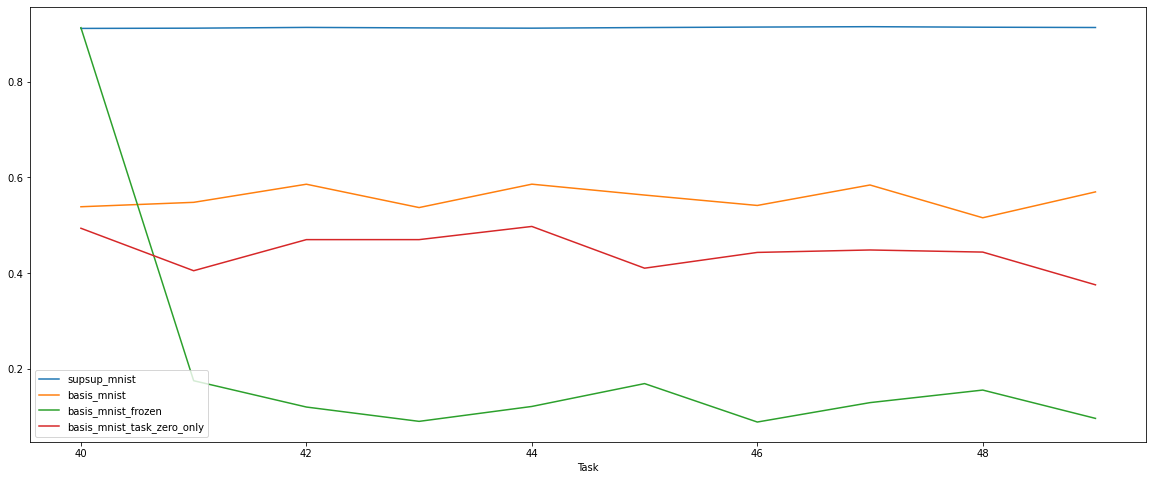

In [135]:
df.reset_index().rename(columns={'index': 'Task'}).set_index('Task')[[c for c in df.columns if 'hybrid' not in c]].loc[40:].plot(figsize=(20,8)) #.style.background_gradient(low=df.min().min(), high=df.max().max(), axis=1).plot()